In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pmdarima


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [ ]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/StockData/Apple.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'High']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

In [ ]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# Tiến hành huấn luyện mô hình SARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['High']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

In [ ]:
import pmdarima as pm
import statsmodels.api as sm

#Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình SARIMAX (đảm bảo rằng seasonal_order được đặt nếu bạn muốn sử dụng SARIMAX)
model_fit = SARIMAX(y_train, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5210.076, Time=7.58 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5204.822, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5204.886, Time=0.62 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5204.609, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5205.863, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5202.959, Time=0.23 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5204.627, Time=0.67 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5206.437, Time=3.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5203.327, Time=0.92 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=5203.635, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=5203.222, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5205.216, Time=2.58 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=5204.394, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 17.786 seconds


In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)

# Dự đoán trên tập kiểm thử (test_data)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['High']).reshape(-1, 1)
y_pred_test = model_fit.predict(start=train_size, end=train_size+len(test_data)-1, exog=exog_test)
y_pred_test

array([182.78826016, 183.02467944, 185.12286176, 185.58584085,
       184.70913861, 184.02944537, 185.64494247, 186.14731805,
       186.63000228, 186.96491867, 188.45235406, 188.61982703,
       192.96392995, 192.37290294, 191.48634024, 190.54069071,
       191.18097367, 188.54102028, 187.86132704, 190.22546467,
       189.72308909, 189.71322963, 192.80633122, 192.81617689,
       196.65790424, 194.9242039 , 193.44661419, 193.38751355,
       192.92453347, 194.10660229, 195.64329362, 195.08181741,
       194.94390904, 195.18031452, 193.65346887, 190.88545277,
       185.97001418, 181.78350999, 178.96623795, 179.61636659,
       179.43906272, 177.3408804 , 178.39490129, 178.18803282,
       177.26207365, 176.24746401, 173.87348071, 174.88809133,
       176.41492221, 180.22711352, 179.78383956, 177.86296112,
       179.28144921, 183.52705502, 186.43299327, 187.68400839,
       188.4720592 , 188.53116082, 187.41805308, 176.9370177 ,
       178.93668714, 178.99578876, 178.82833056, 176.04

In [ ]:
# Dự đoán giá 30 ngày tiếp theo

next_dates = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')

mean_volume = np.mean(df['High'])
exog_next = np.full((30, 1), mean_volume)
# Tính chỉ số bắt đầu và kết thúc cho dự đoán
start_index = len(df) - len(y_test)
end_index = len(df) - 1

# Tạo mảng exogenous kết hợp cho tập kiểm thử và 30 ngày tiếp theo
exog_combined = np.concatenate((exog_test, exog_next))

# Dự đoán cho tập kiểm thử và 30 ngày tiếp theo
y_pred_combined = model_fit.predict(start=train_size, end=train_size + len(test_data) + 29, exog=exog_combined)

# Tách phần dự đoán cho 30 ngày tiếp theo
y_pred_next_30_days = y_pred_combined[-30:]

# Chuẩn bị DataFrame cho đồ thị
next_30_days = pd.DataFrame({'Date': next_dates, 'Predicted_Close': y_pred_next_30_days})
y_pred_combined



array([182.78826016, 183.02467944, 185.12286176, 185.58584085,
       184.70913861, 184.02944537, 185.64494247, 186.14731805,
       186.63000228, 186.96491867, 188.45235406, 188.61982703,
       192.96392995, 192.37290294, 191.48634024, 190.54069071,
       191.18097367, 188.54102028, 187.86132704, 190.22546467,
       189.72308909, 189.71322963, 192.80633122, 192.81617689,
       196.65790424, 194.9242039 , 193.44661419, 193.38751355,
       192.92453347, 194.10660229, 195.64329362, 195.08181741,
       194.94390904, 195.18031452, 193.65346887, 190.88545277,
       185.97001418, 181.78350999, 178.96623795, 179.61636659,
       179.43906272, 177.3408804 , 178.39490129, 178.18803282,
       177.26207365, 176.24746401, 173.87348071, 174.88809133,
       176.41492221, 180.22711352, 179.78383956, 177.86296112,
       179.28144921, 183.52705502, 186.43299327, 187.68400839,
       188.4720592 , 188.53116082, 187.41805308, 176.9370177 ,
       178.93668714, 178.99578876, 178.82833056, 176.04

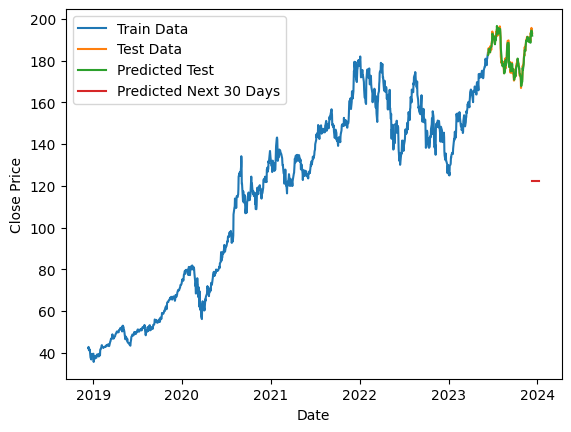

In [ ]:
# Vẽ đồ thị
#plt.figure(figsize=(15, 8))
plt.plot(train_data['Date'], train_data['Close'], label='Train Data')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data')
plt.plot(test_data['Date'], y_pred_test, label='Predicted Test')
plt.plot(next_30_days['Date'], next_30_days['Predicted_Close'], label='Predicted Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Tính MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Tính toán RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Làm tròn đến số thứ 3 sau dấu phẩy
test_mae = round(test_mae, 3)
test_rmse = round(test_rmse, 3)
test_mape = round(test_mape, 3)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 0.154
Testing RMSE: 0.199
Testing MAPE: 4.419


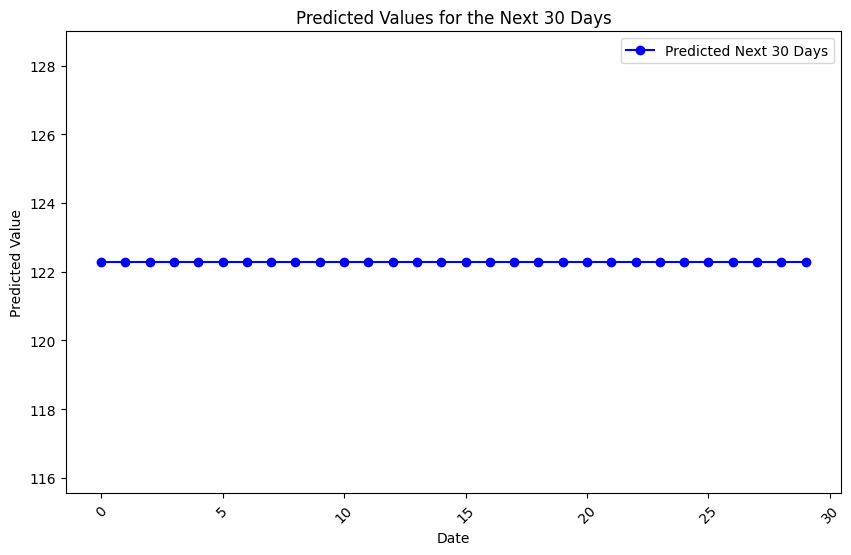

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(y_pred_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()


